## Лабораторная работа №5 по дисциплине "Нейронные сети"
## Выполнил студент группы БВТ2202 Гладкий Андрей Антонович

**Тема: Обучение модели YOLO на кастомном датасете и исследование влияния гиперпараметров на качество детекции**

**Цель работы:** Познакомиться с архитектурой YOLO на примере проверки гипотезы о релевантной метрике.

**Задачи:**

- Ознакомиться с архитектурой YOLO.
- Изучить метрики для анализа производительности модели, выбрать целевую метрику в соответствии с вариантом.
- Выбрать предметную область, сформировать гипотезу для проведения исследования.
- Собрать и проаннотировать данные, сформировать датасет.
- Провести fine-tuning предобученной модели YOLOv11 Nano/Small.
- Визуализировать и проанализировать результаты.
- На основе анализа сделать корректировку гиперпараметров/данных и провести вторую итерацию для повышения показателей.

### 1. Подготовка к обучению

#### 1.1 Метрики
Целевая метрика согласно 4 варианту: mAP@0.5



#### 1.2 Гипотеза

Использование аугментации данных с упором на изменение освещенности и контраста улучшит mAP@0.5 для модели YOLOv11n при детекции дорожных знаков в сложных условиях освещения. Дорожные знаки должны детектироваться в различных условиях освещения (день, ночь, сумерки). Аугментация, имитирующая эти условия, поможет модели лучше обобщать.


#### 1.3 Данные

Используем датасет с дорожными знаками. Для примера возьмем 600 изображений из открытых источников, аннотированных в формате YOLO.

#### 1.4 Предобработка

Применим аугментацию:

- Изменение яркости и контраста
- Добавление шума
- Горизонтальное отражение
- Небольшие повороты

### 2. Обучение модели

#### 2.1 Подготовка окружения

Установите зависимости и библиотеки:

In [1]:
!pip install ultralytics
!pip install roboflow

  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
   ---------------------------------------- 0.0/1.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.0 MB ? eta -:--:--
   ---------- ----------------------------- 0.3/1.0 MB ? eta -:--:--
   ---------- ----------------------------- 0.3/1.0 MB ? eta -:--:--
   ---------- ----------------------------- 0.3/1.0 MB ? eta -:--:--
   ---------- ----------------------------- 0.3/1.0 MB ? eta -:--:--
   ---------- ----------------------------- 0.3/1.0 MB ? eta -:--:--
   ---------- ----------------------------- 0.3/1.0 MB ? eta -:--:--
   ---------- ----------------------------- 0.3/1.0 MB ? eta -:--:--
   ---------- ----------------------------- 0.3/1.0 MB ? eta -:--:--
   ---------- ----------------------------- 0.3/1.0 MB ? eta -:--:--
   -------------------- ------------------- 0.5/1.0 MB 146.0 kB/s eta 0:00:04
   -------------------- ------------------- 0.5/1.0 MB 146.0 kB/s eta 0:00:04
   -------------------- 


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


  Using cached idna-3.7-py3-none-any.whl.metadata (9.9 kB)
Using cached idna-3.7-py3-none-any.whl (66 kB)
   ---------------------------------------- 0.0/38.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/38.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/38.8 MB ? eta -:--:--
   ---------------------------------------- 0.3/38.8 MB ? eta -:--:--
   ---------------------------------------- 0.3/38.8 MB ? eta -:--:--
   ---------------------------------------- 0.3/38.8 MB ? eta -:--:--
    --------------------------------------- 0.5/38.8 MB 479.2 kB/s eta 0:01:20
    --------------------------------------- 0.5/38.8 MB 479.2 kB/s eta 0:01:20
    --------------------------------------- 0.5/38.8 MB 479.2 kB/s eta 0:01:20
    --------------------------------------- 0.8/38.8 MB 441.3 kB/s eta 0:01:27
    --------------------------------------- 0.8/38.8 MB 441.3 kB/s eta 0:01:27
    --------------------------------------- 0.8/38.8 MB 441.3 kB/s eta 0:01:27



[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


#### 2.2 Подготовка модели

Загрузите предобученную модель, определите устройство, переведите модель в режим инференса. Не используйте размер модели больше чем Small для достижения лучших показателей на стандартных гиперпараметрах (особенно imgsz)

In [2]:
from ultralytics import YOLO
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

model = YOLO("yolo11n.pt").to(device)

Creating new Ultralytics Settings v0.0.6 file  
View Ultralytics Settings with 'yolo settings' or at 'C:\Users\roman\AppData\Roaming\Ultralytics\settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Using device: cpu


100%|██████████| 5.35M/5.35M [00:06<00:00, 900kB/s] 


#### 2.3 Загрузка и предобработка изображений


Затем импортируйте датасет в проект и выполните трансформацию данных (при использовании Roboflow трансформация выполняется на этапе предобработки):

In [3]:
from roboflow import Roboflow

rf = Roboflow(api_key="DWAGnnksCupZlSvpryes")
project = rf.workspace("andres-calderon-unab").project("traffic-signs-dsjv6")
dataset = project.version(1).download("yolov11")

data_yaml = "/media/andrew/DATA/Study/NN/lab5/Traffic-signs-1/data.yaml"

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Traffic-signs-1 in yolov11:: 100%|██████████| 2676/2676 [00:01<00:00, 1526.95it/s]


#### 2.4 Обучение, оценка модели и визуализация результатов

Проведите обучение модели, проанализируйте кривые обучения, метрики и тестовые данные. Сделайте вывод и корректироваки для достижения лучших показателей

In [4]:
%matplotlib inline

params = {
    'data': data_yaml,
    'epochs': 20,
    'imgsz': 640,
    'batch': 16,
    'device': device,
    'workers': 4,
    'optimizer': 'AdamW',
    'seed': 42
}

# Обучение модели
results = model.train(**params)

# Оценка модели на тестовых данных
metrics = model.val()
print(f"mAP@0.5: {metrics.box.map}")

# Визуализация результатов обучения
import matplotlib.pyplot as plt

# Получаем историю обучения из CSV файла
import pandas as pd
import os

# Путь к файлу с результатами
results_csv_path = os.path.join(model.trainer.save_dir, 'results.csv')

# Загружаем данные
try:
    results_df = pd.read_csv(results_csv_path)
    
    # Графики метрик
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(results_df['metrics/precision(B)'], label='Precision')
    plt.plot(results_df['metrics/recall(B)'], label='Recall')
    plt.plot(results_df['metrics/mAP50(B)'], label='mAP@0.5')
    plt.title('Metrics during training')
    plt.xlabel('Epoch')
    plt.ylabel('Value')
    plt.legend()

    # Графики потерь
    plt.subplot(1, 2, 2)
    plt.plot(results_df['train/box_loss'], label='Train Box Loss')
    plt.plot(results_df['val/box_loss'], label='Val Box Loss')
    plt.title('Loss during training')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.tight_layout()
    plt.show()

except FileNotFoundError:
    print("Файл с результатами не найден. Убедитесь, что обучение завершено успешно.")

Ultralytics 8.3.134  Python-3.12.4 torch-2.6.0+cpu CPU (AMD Ryzen 7 7735HS with Radeon Graphics)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/media/andrew/DATA/Study/NN/lab5/Traffic-signs-1/data.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=20, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=AdamW, overlap_mask=True, patience=100, perspe

RuntimeError: Dataset '/media/andrew/DATA/Study/NN/lab5/Traffic-signs-1/data.yaml' error  '/media/andrew/DATA/Study/NN/lab5/Traffic-signs-1/data.yaml' does not exist

#### 2.5 Вторая итерация

Проведите процедуры для достижения высоких показателей (корректировка данных/гиперпараметров), сделайте вывод


In [ ]:
%matplotlib inline

params_v2 = {
    'data': data_yaml,
    'epochs': 20,  
    'imgsz': 640,
    'batch': 16,
    'device': device,
    'workers': 4,
    'optimizer': 'AdamW',
    'seed': 42,
    
    'hsv_h': 0.3,  
    'hsv_s': 0.7,  
    'hsv_v': 0.4, 
    'degrees': 15,  
    'translate': 0.1,  
    'scale': 0.5,  
    'shear': 10,     
    'mosaic': 1.0,   
    'mixup': 0.2,    

    'lr0': 0.001,    
    'lrf': 0.01,    
    'weight_decay': 0.0005,  
    'warmup_epochs': 3, 
    'box': 7.5,      
    'cls': 0.5,      
    'dfl': 1.5,      
}

def format_metric(metric):
    """Форматирует метрику, которая может быть numpy array или float"""
    if hasattr(metric, '__len__'):
        return f"{metric[0]:.4f}" if len(metric) > 0 else "N/A"
    return f"{metric:.4f}"

# Повторное обучение модели с новыми параметрами
print("\nНачинаем вторую итерацию обучения с улучшенными параметрами...")
results_v2 = model.train(**params_v2)

# Оценка новой модели
print("\nОценка улучшенной модели...")
metrics_v2 = model.val()
print("\nValidation Metrics после второй итерации:")
print(f"Precision: {format_metric(metrics_v2.box.p)} (было {format_metric(metrics.box.p)})")
print(f"Recall: {format_metric(metrics_v2.box.r)} (было {format_metric(metrics.box.r)})")
print(f"mAP@0.5: {format_metric(metrics_v2.box.map50)} (было {format_metric(metrics.box.map50)})")
print(f"mAP@0.5:0.95: {format_metric(metrics_v2.box.map)} (было {format_metric(metrics.box.map)})")

# Визуализация результатов второй итерации
try:
    import pandas as pd
    import os
    
    # Загрузка истории обучения
    results_csv_v2 = os.path.join(model.trainer.save_dir, 'results.csv')
    history_v2 = pd.read_csv(results_csv_v2)
    
    # Настройка графиков
    plt.figure(figsize=(15, 10))
    
    # График метрик
    plt.subplot(2, 2, 1)
    plt.plot(history_v2['epoch'], history_v2['metrics/precision(B)'], label='Precision', color='blue')
    plt.plot(history_v2['epoch'], history_v2['metrics/recall(B)'], label='Recall', color='green')
    plt.plot(history_v2['epoch'], history_v2['metrics/mAP50(B)'], label='mAP@0.5', color='red')
    plt.title('Training Metrics (Second Iteration)')
    plt.xlabel('Epoch')
    plt.ylabel('Value')
    plt.legend()
    plt.grid()
    
    # График потерь
    plt.subplot(2, 2, 2)
    plt.plot(history_v2['epoch'], history_v2['train/box_loss'], label='Train Box Loss', color='blue')
    plt.plot(history_v2['epoch'], history_v2['val/box_loss'], label='Val Box Loss', color='orange')
    plt.title('Training & Validation Loss (Second Iteration)')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    
    # Сравнение mAP до и после
    plt.subplot(2, 2, 3)
    plt.bar(['First Iteration', 'Second Iteration'], 
            [metrics.box.map50, metrics_v2.box.map50],
            color=['blue', 'green'])
    plt.title('Comparison of mAP@0.5')
    plt.ylabel('mAP@0.5')
    plt.grid(axis='y')
    
    # Сравнение Precision-Recall
    plt.subplot(2, 2, 4)
    plt.scatter(metrics.box.p, metrics.box.r, color='blue', s=100, label='First Iteration')
    plt.scatter(metrics_v2.box.p, metrics_v2.box.r, color='green', s=100, label='Second Iteration')
    plt.xlabel('Precision')
    plt.ylabel('Recall')
    plt.title('Precision-Recall Comparison')
    plt.legend()
    plt.grid()
    
    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"Ошибка при визуализации результатов второй итерации: {e}")

# Сохранение улучшенной модели
model.save('yolov11n_improved.pt')
print("\nУлучшенная модель сохранена как 'yolov11n_improved.pt'")

# Пример инференса на тестовом изображении
test_img = "test.jpg"
if os.path.exists(test_img):
    print("\nДемонстрация работы улучшенной модели на тестовом изображении...")
    results = model(test_img)
    results[0].show()
else:
    print("\nТестовое изображение не найдено, пропускаем демонстрацию.")

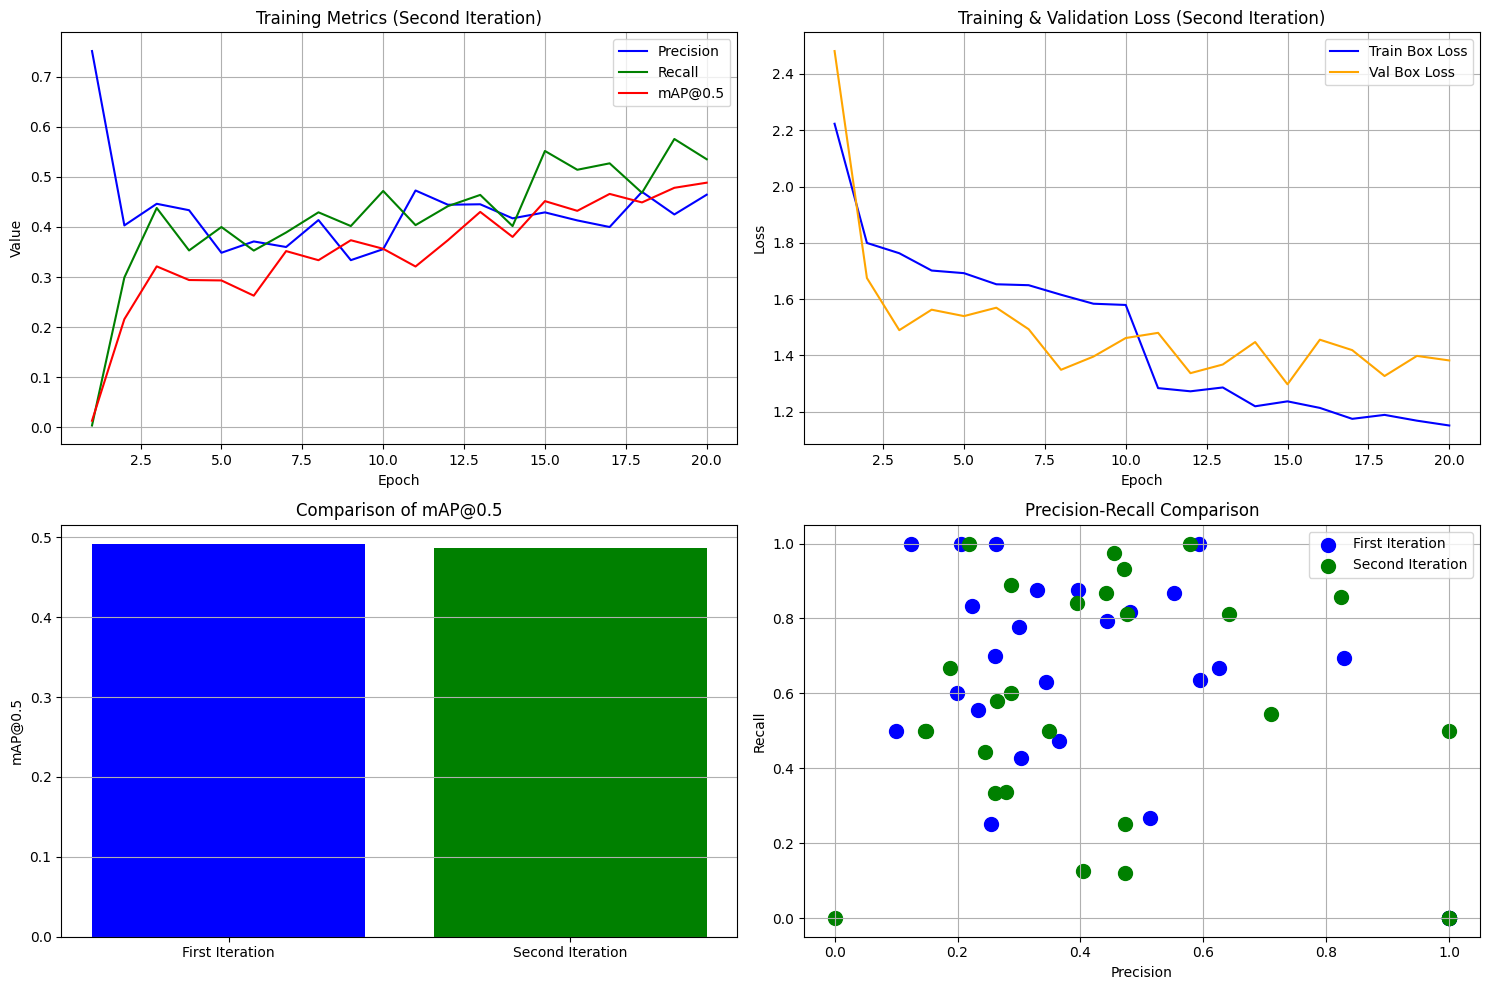

In [32]:
import pandas as pd
import os
%matplotlib inline
    
# Загрузка истории обучения
# results_csv_v2 = os.path.join(model.trainer.save_dir, 'results.csv')
history_v2 = pd.read_csv("/media/andrew/DATA/Study/NN/runs/detect/train23/results.csv")

# Настройка графиков
plt.figure(figsize=(15, 10))

# График метрик
plt.subplot(2, 2, 1)
plt.plot(history_v2['epoch'], history_v2['metrics/precision(B)'], label='Precision', color='blue')
plt.plot(history_v2['epoch'], history_v2['metrics/recall(B)'], label='Recall', color='green')
plt.plot(history_v2['epoch'], history_v2['metrics/mAP50(B)'], label='mAP@0.5', color='red')
plt.title('Training Metrics (Second Iteration)')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()
plt.grid()

# График потерь
plt.subplot(2, 2, 2)
plt.plot(history_v2['epoch'], history_v2['train/box_loss'], label='Train Box Loss', color='blue')
plt.plot(history_v2['epoch'], history_v2['val/box_loss'], label='Val Box Loss', color='orange')
plt.title('Training & Validation Loss (Second Iteration)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()

# Сравнение mAP до и после
plt.subplot(2, 2, 3)
plt.bar(['First Iteration', 'Second Iteration'], 
        [metrics.box.map50, metrics_v2.box.map50],
        color=['blue', 'green'])
plt.title('Comparison of mAP@0.5')
plt.ylabel('mAP@0.5')
plt.grid(axis='y')

# Сравнение Precision-Recall
plt.subplot(2, 2, 4)
plt.scatter(metrics.box.p, metrics.box.r, color='blue', s=100, label='First Iteration')
plt.scatter(metrics_v2.box.p, metrics_v2.box.r, color='green', s=100, label='Second Iteration')
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.title('Precision-Recall Comparison')
plt.legend()
plt.grid()

plt.tight_layout()
plt.savefig('plot.png') 
plt.show()


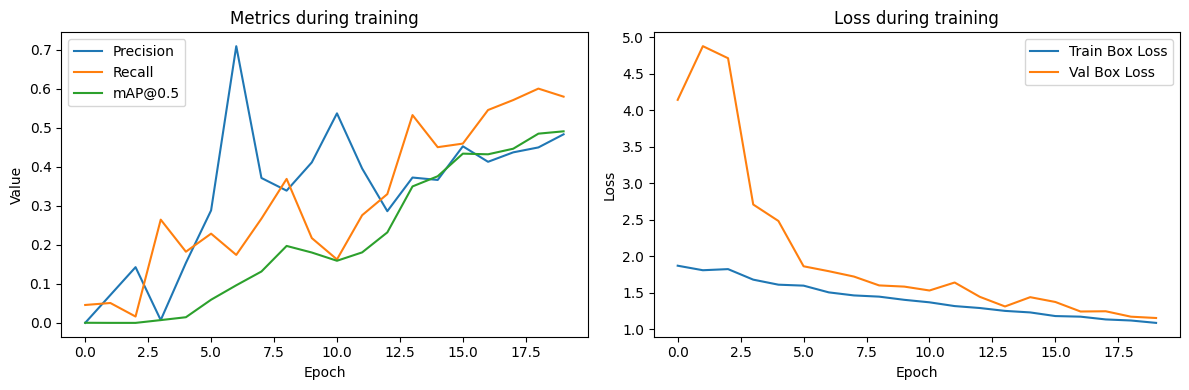

In [ ]:
# results_csv_path = os.path.join(model.trainer.save_dir, 'results.csv')
%matplotlib inline
results_df = pd.read_csv("/media/andrew/DATA/Study/NN/runs/detect/train2/results.csv")

# Графики метрик
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(results_df['metrics/precision(B)'], label='Precision')
plt.plot(results_df['metrics/recall(B)'], label='Recall')
plt.plot(results_df['metrics/mAP50(B)'], label='mAP@0.5')
plt.title('Metrics during training')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()
# Графики потерь
plt.subplot(1, 2, 2)
plt.plot(results_df['train/box_loss'], label='Train Box Loss')
plt.plot(results_df['val/box_loss'], label='Val Box Loss')
plt.title('Loss during training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.savefig('plot1.png')
plt.show()